In [52]:
import numpy as np
import matplotlib.pyplot as plt
import json 
import os 
import copy

if os.getcwd() == '/Users/cd8607/Documents/Fitting_Potential':
    pass
else:
    os.chdir('../')
    
class ZBL():

    def __init__(self, Zi, Zj):
        
        self.Zi = Zi
        self.Zj = Zj

        e0 = 55.26349406e-4

        K = 1/(4*np.pi*e0)

        self.a = 0.46850/(self.Zi**0.23 + self.Zj**0.23)	

        self.amplitude = np.array([0.18175, 0.50986, 0.28022, 0.02817])
        self.exponent = np.array([3.19980, 0.94229, 0.40290, 0.20162])

        self.constant = K*Zi*Zj

    def eval_zbl(self, rij):

        if isinstance(rij, (int, float)):
            rij = np.array([rij])

        x = rij/self.a

        x = x[:, np.newaxis]

        phi = np.sum(self.amplitude * np.exp(-self.exponent * x), axis=1)
            
        return (self.constant/rij)*phi

    def eval_grad(self, rij):

        if isinstance(rij, (int, float)):
            rij = np.array([rij])

        x = rij/self.a

        x = x[:, np.newaxis]

        phi = np.sum(self.amplitude * np.exp(-self.exponent * x), axis=1)
        
        dphi = np.sum(-self.amplitude*self.exponent * np.exp(-self.exponent * x), axis=1)

        return (self.constant/rij)*(dphi/self.a - phi/rij)
    
    def eval_hess(self, rij):

        if isinstance(rij, (int, float)):
            rij = np.array([rij])
            
        x = rij/self.a

        x = x[:, np.newaxis]

        phi = np.sum(self.amplitude * np.exp(-self.exponent * x), axis=1)
        
        dphi = np.sum(-self.amplitude*self.exponent * np.exp(-self.exponent * x), axis=1)

        d2phi = np.sum(self.amplitude*self.exponent**2 * np.exp(-self.exponent * x), axis=1)

        return (self.constant/rij)*(d2phi/self.a**2 - 2*dphi/(self.a*rij) + 2*phi/rij**2)

In [53]:
def fit_sample(sample, F_nknots = 3, Rho_nknots = 3, V_nknots = 4):

    ''' Sample ordered as follows: F(He), Rho(He), V(W-He), V(H-He), V(He-He) '''
    ''' Inside of each of the above params: sqrt_coef(if it exists), x_knot, y_knot, dy_knot, d2y_knot'''

    map = {}

    keys  = ['He_F(rho)','He_rho(r)', 'W-He', 'H-He', 'He-He']
    items = ['knots', 'y', 'dy', 'd2y']

    splice_F = [F_nknots - 1, F_nknots - 2, F_nknots - 1, F_nknots - 1]
    splice_Rho = [Rho_nknots - 1, Rho_nknots - 1, Rho_nknots - 1, Rho_nknots - 1]
    splice_V = [V_nknots - 1, V_nknots - 2, V_nknots - 2, V_nknots - 2]

    splices = splice_F + splice_Rho + 3*splice_V

    idx = 1
    iter = 0
    for key in keys:
        map[key] = {}
        for item in items:
            map[key][item] = [i for i in range(idx, idx + splices[iter])]
            idx += splices[iter]
            iter += 1

    coef_dict   = {}
    knot_dict = {}

    coef_dict['sqrt_coef He_F'] = sample[0]

    key = 'He_F(rho)'
    coef_dict[key], knot_dict[key] = fit_F(sample[map[key]['knots']], sample[map[key]['y']], sample[map[key]['dy']], sample[map[key]['d2y']])

    key = 'He_rho(r)'
    coef_dict[key], knot_dict[key] = fit_Rho(sample[map[key]['knots']], sample[map[key]['y']], sample[map[key]['dy']], sample[map[key]['d2y']])

    key = 'W-He'
    coef_dict[key], knot_dict[key] = fit_V(sample[map[key]['knots']], sample[map[key]['y']], sample[map[key]['dy']], sample[map[key]['d2y']])

    key = 'H-He'
    coef_dict[key], knot_dict[key] = fit_V(sample[map[key]['knots']], sample[map[key]['y']], sample[map[key]['dy']], sample[map[key]['d2y']])

    key = 'He-He'
    coef_dict[key], knot_dict[key] = fit_V(sample[map[key]['knots']], sample[map[key]['y']], sample[map[key]['dy']], sample[map[key]['d2y']])

    return coef_dict, knot_dict
    
def update_potfile(pot_dict, pot_params, coef_dict, knot_dict):

    rho = np.linspace(0, pot_params['drho']*(pot_params['Nrho']-1), pot_params['Nrho'])

    pot_dict['He_F(rho)'] = eval_F(rho, coef_dict['sqrt_coef He_F'], coef_dict['He_F(rho)'], knot_dict['He_F(rho)'])

    r = np.linspace(0, pot_params['dr']*(pot_params['Nr']-1), pot_params['Nr'])

    pot_dict['He_rho(r)'] = eval_Rho(r, coef_dict['He_rho(r)'], knot_dict['He_rho(r)'])

    charge = [[74, 2], [1, 2], [2,2]]

    for i, key in enumerate(['W-He', 'H-He', 'He-He']):
        
        pot_dict[key][1:] = r[1:]*eval_V(r[1:], coef_dict[key], knot_dict[key], charge[i][0], charge[i][1])

    return pot_dict

def extend_sample(sample, x, y, dy, d2y):
    for element in [x, y, dy, d2y]:
        for val in element:
            sample.append(val)
    return sample

def init_sample(pot_params, F_nknots = 3, Rho_nknots = 3, V_nknots = 4, dof = 6):

    sample = []

    with open("Init.json", "r") as json_file:
        loaded_data = json.load(json_file)

    pot = {}
    for key, value in loaded_data.items():
        pot[key] = np.array(value)

    Nrho = pot_params['Nrho']
    drho = pot_params['drho']
    Nr   = pot_params['Nr']
    dr   = pot_params['dr']
    rc   = pot_params['rc']

    coef_dict   = {}
    knot_dict = {}

    coef_dict['sqrt_coef He_F'] = 0

    sample.append(coef_dict['sqrt_coef He_F'])

    knots = np.linspace(0, 2*drho*Nrho, F_nknots)
    y = 0.37*knots[1:-1]
    dy = 0.37*np.ones((F_nknots - 1,))
    d2y = np.zeros((F_nknots - 1,))
    
    sample = extend_sample(sample, knots[1:], y, dy, d2y)
    coef_dict['He_F(rho)'], knot_dict['He_F(rho)'] = fit_F(knots[1:], y, dy, d2y)

    knots = np.linspace(0, dr*Nr, Rho_nknots)
    y = np.zeros((Rho_nknots - 1,))
    dy = np.zeros((Rho_nknots - 1,))
    d2y = np.zeros((Rho_nknots - 1,))

    sample = extend_sample(sample, knots[1:], y, dy, d2y)
    coef_dict['He_rho(r)'], knot_dict['He_rho(r)'] = fit_Rho(knots[1:], y, dy, d2y)

    knots = np.linspace(0, dr*Nr, V_nknots)

    knots_idx = (knots/dr).astype(int)

    charge = [[74, 2], [1, 2], [2,2]]

    for i, key in enumerate(['W-He', 'H-He', 'He-He']):
        
        zbl_class = ZBL(charge[i][0], charge[i][1])

        f = pot[key][knots_idx[1:-1]]/knots[1:-1]
        f_backward = pot[key][knots_idx[1:-1] - 1]/(knots[1:-1]-dr)
        f_forward = pot[key][knots_idx[1:-1] + 1]/(knots[1:-1]+dr)
        
        y = f - zbl_class.eval_zbl(knots[1:-1])
        dy = (f-f_backward)/dr - zbl_class.eval_grad(knots[1:-1])
        d2y = (f_forward - 2*f + f_backward)/dr**2 - zbl_class.eval_hess(knots[1:-1])

        coef_dict[key], knot_dict[key] = fit_V(knots[1:], y, dy,d2y, Zi = charge[i][0], Zj = charge[i][1])

        sample = extend_sample(sample, knots[1:], y, dy, d2y)
        
    return coef_dict, knot_dict, np.array(sample)
    
def eval_piecewise_poly(x, coef, knots):

    dof = coef.shape[1]

    n = len(knots)

    lower_bound = knots[np.arange(n-1)]
    upper_bound = knots[np.arange(1,n)]

    masks = np.array( [( (lower_bound[i] <= x) & (x < upper_bound[i]) ).astype(int) for i in range(n-1)])

    Psi = np.array([x**i for i in range(dof)])
    
    return np.sum( np.array([ masks[i]*(coef[i]@Psi) for i in range(n-1)]), axis = 0)

def eval_V(r, coef, knots, Zi = 74, Zj = 2):

    poly = eval_piecewise_poly(r, coef, knots)
    zbl_class = ZBL(Zi, Zj)
    mask = (r < knots[-2]).astype(int)
    zbl = mask * zbl_class.eval_zbl(r)

    return poly + zbl

def eval_F(r, sqrt_coef, poly_coef, knots):

    poly = eval_piecewise_poly(r, poly_coef, knots)

    sqrt = sqrt_coef*np.sqrt(r)

    return poly + sqrt

def eval_Rho(r, coef, knots):

    Rho =  eval_piecewise_poly(r, coef, knots)

    return Rho

def fit_piecewise_poly(x_knot, y_knot, dy_knot, d2y_knot, dof = 6 ):
    
    n = len(x_knot)
    
    pairs = np.column_stack( [np.arange(n-1), np.arange(1,n)] )

    coef  = np.zeros((n-1, dof))

    for j in range(n-1):

        psi_y = np.array([x_knot[pairs[j]]**i for i in range(dof)]).T

        psi_dy = np.array([i*x_knot[pairs[j]]**np.clip(i-1, a_min=0, a_max=None) for i in range(dof)]).T

        psi_d2y = np.array([i*(i-1)*x_knot[pairs[j]]**np.clip(i-2, a_min=0, a_max=None) for i in range(dof)]).T

        Psi = np.vstack([psi_y, psi_dy, psi_d2y])

        Y = np.hstack([y_knot[pairs[j]], dy_knot[pairs[j]], d2y_knot[pairs[j]]])

        coef[j] = np.linalg.inv(Psi.T@Psi) @ Psi.T @ Y
        
    return coef


def fit_poly(x, y, dy, d2y, dof = 6):

    psi_y = np.array([x**i for i in range(dof)]).T

    psi_dy = np.array([i*x**np.clip(i-1, a_min=0, a_max=None) for i in range(dof)]).T

    psi_d2y = np.array([i*(i-1)*x**np.clip(i-2, a_min=0, a_max=None) for i in range(dof)]).T

    Psi = np.vstack([psi_y, psi_dy, psi_d2y])

    Y = np.hstack([y, dy, d2y])

    coef = np.linalg.inv(Psi.T@Psi) @ Psi.T @ Y

    return coef

def fit_poly_onlyfunc(x, y, dof = 6):

    Psi = np.array([x**i for i in range(dof)]).T

    coef = np.linalg.inv(Psi.T@Psi) @ Psi.T @ y

    return coef

def fit_V(x, y, dy, d2y, dof = 6, Zi = 74, Zj = 2):

    n = len(y) + 2

    x_knot = np.zeros((n,))
    y_knot = np.zeros((n,))
    dy_knot = np.zeros((n,))
    d2y_knot = np.zeros((n,))
    
    x_knot[1:] = x
    y_knot[1:-1] = y
    dy_knot[1:-1] = dy
    d2y_knot[1:-1] = d2y


    x_with_index = np.column_stack([x_knot, np.arange(n)])

    x_with_index = x_with_index[np.argsort(x_with_index[:,0])]

    x_knot = x_with_index[:,0]

    x_index = x_with_index[:,1].astype(int)

    y_knot = y_knot[x_index]
    dy_knot = dy_knot[x_index]
    d2y_knot = d2y_knot[x_index]

    zbl_class = ZBL(Zi, Zj)
    
    # y_knot[-1] = -zbl_class.eval_zbl(x_knot[-1])
    # dy_knot[-1] = -zbl_class.eval_grad(x_knot[-1])
    # d2y_knot[-1] = -zbl_class.eval_hess(x_knot[-1])

    # coef = fit_piecewise_poly(x_knot, y_knot, dy_knot, d2y_knot)

    coef = np.zeros((n-1, dof))

    coef[:-1] = fit_piecewise_poly(x_knot[:-1], y_knot[:-1], dy_knot[:-1], d2y_knot[:-1])

    y_knot[-2] += zbl_class.eval_zbl(x_knot[-2])
    dy_knot[-2] += zbl_class.eval_grad(x_knot[-2])
    d2y_knot[-2] += zbl_class.eval_hess(x_knot[-2])
        
    coef[-1] = fit_poly(x_knot[-2:], y_knot[-2:], dy_knot[-2:], d2y_knot[-2:])
        
    return coef, x_knot

def fit_F(x, y, dy, d2y, dof = 6):

    n = len(x) + 1

    x_knot = np.zeros((n,))
    y_knot = np.zeros((n,))
    dy_knot = np.zeros((n,))
    d2y_knot = np.zeros((n,))
    
    x_knot[1:] = x
    y_knot[1:-1] = y
    dy_knot[:-1] = dy
    d2y_knot[:-1] = d2y

    x_with_index = np.column_stack([x_knot, np.arange(n)])

    x_with_index = x_with_index[np.argsort(x_with_index[:,0])]

    x_knot = x_with_index[:,0]

    x_index = x_with_index[:,1].astype(int)

    y_knot = y_knot[x_index]
    dy_knot = dy_knot[x_index]
    d2y_knot = d2y_knot[x_index]

    coef = fit_piecewise_poly(x_knot, y_knot, dy_knot, d2y_knot, dof)

    return coef, x_knot

def fit_Rho(x, y, dy, d2y, dof = 6):

    n = len(x) + 1

    x_knot = np.zeros((n,))
    y_knot = np.zeros((n,))
    dy_knot = np.zeros((n,))
    d2y_knot = np.zeros((n,))
    
    x_knot[1:] = x
    y_knot[:-1] = y
    dy_knot[:-1] = dy
    d2y_knot[:-1] = d2y

    x_with_index = np.column_stack([x_knot, np.arange(n)])

    x_with_index = x_with_index[np.argsort(x_with_index[:,0])]

    x_knot = x_with_index[:,0]

    x_index = x_with_index[:,1].astype(int)

    y_knot = y_knot[x_index]
    dy_knot = dy_knot[x_index]
    d2y_knot = d2y_knot[x_index]
    
    coef = fit_piecewise_poly(x_knot, y_knot, dy_knot, d2y_knot, dof)

    return coef, x_knot

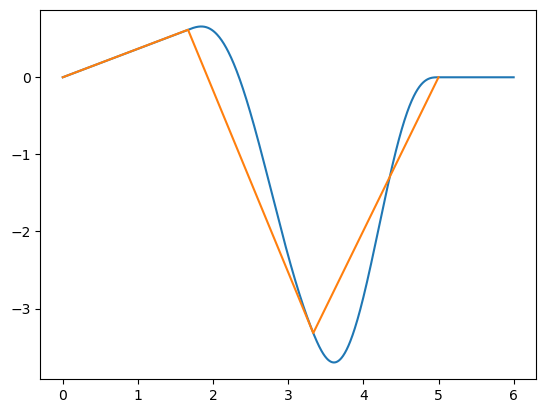

In [54]:
# Sample input array r
r = np.linspace(0,10,4)
n = 4

knots = np.linspace(0, 5, n)

eval_piecewise_poly(r, np.random.randn(n-1, 6), knots)

pairs = np.column_stack( [np.arange(n-1), np.arange(1,n)] )

y =  2*np.random.randn(n)
dy = 2*np.random.randn(n)
d2y =  2*np.random.randn(n)

y[0] = 0
dy[0] = 0.37
d2y[0] = 0

y[1] = 0.37*knots[1]
dy[1] = 0.37
d2y[1] = 0

y[-1] = 0
dy[-1] = 0
d2y[-1] = 0

coef = fit_piecewise_poly(knots, y, dy, d2y)

x_test = np.linspace(0,6,1000)

y_test = eval_F(x_test, 0,coef, knots)

plt.plot(x_test,y_test)
plt.plot(knots, y)

(3,)


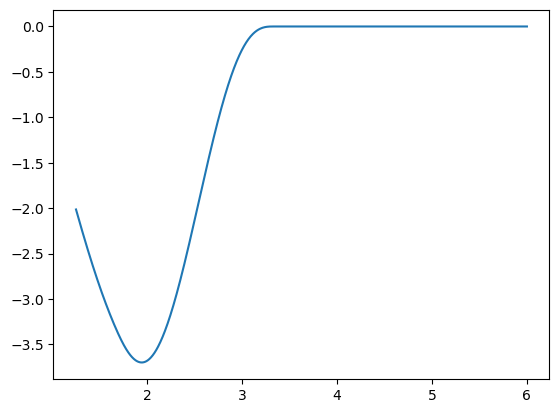

In [55]:
coef, x_knots = fit_Rho(knots[1:n-1], y[1:n-1], dy[1:n-1], d2y[1:n-1])

x_test = np.linspace(1.25, 6, 1000)

print(x_knots.shape)

y_test = eval_Rho(x_test, coef, x_knots)

plt.plot(x_test,y_test)


[[ 4.78172229e-13  2.62224174e-13  4.32968756e-14  7.99200000e-01
  -6.39360000e-01  1.43856000e-01]
 [ 5.62805558e+01 -1.26556956e+02  1.09933426e+02 -4.52839420e+01
   8.80772050e+00 -6.54675630e-01]
 [-2.22549761e+03  2.84466747e+03 -1.43308042e+03  3.55167878e+02
  -4.33228780e+01  2.08319517e+00]] [0.         1.66666667 3.33333333 5.        ]


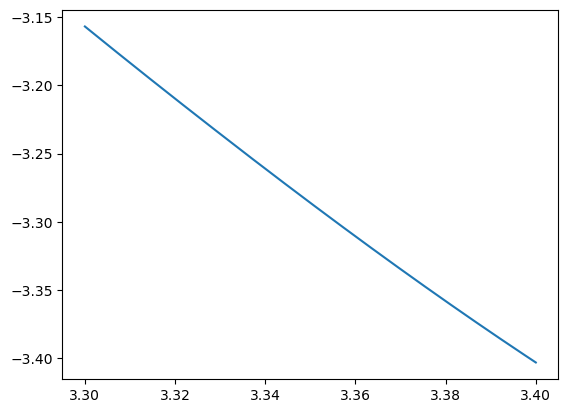

In [56]:
coef, x_knots = fit_V(knots[1:n], y[1:n-1], dy[1:n-1], d2y[1:n-1])

x_test = np.linspace(3.3, 3.4, 10000)

print(coef, x_knots)

y_test = eval_V(x_test, coef, x_knots)

plt.plot(x_test,y_test)

(43,)
[0.         1.61712967 3.23425933 4.851389  ]


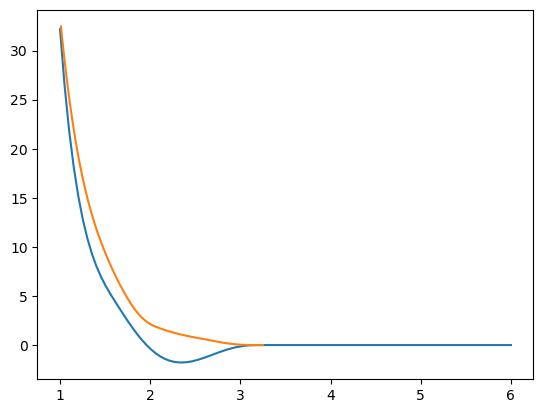

In [57]:
pot_params = {}

pot_params['Nrho'] = 10000
pot_params['drho'] = 0.0019792116    
pot_params['Nr']   = 5000
pot_params['dr']   = 0.0009702778    
pot_params['rc']  = 4.8513889200


coef_dict, knot_dict, sample = init_sample(pot_params, F_nknots=3, Rho_nknots=3, V_nknots=4)

print(sample.shape)

x_test = np.linspace(1,6,100)

y_test = eval_V(x_test, coef_dict['W-He'], knot_dict['W-He'])

whe = np.loadtxt('Potentials/W-He-Juslin.table',skiprows=6)[:,1:3]

print(knot_dict['W-He'])

plt.plot(x_test, y_test)

plt.plot(whe[100:, 0], whe[100:,1]*whe[100:,0])

{'sqrt_coef He_F': 0.0, 'He_F(rho)': array([[ 2.32848444e-09,  3.70000000e-01, -2.43921160e-10,
         3.66915881e-11, -2.01357865e-12,  3.75136154e-14],
       [ 2.89699896e-04,  3.05662917e-03,  2.07393532e-02,
         1.61007082e-03, -1.20048000e-04,  1.66963517e-06]]), 'He_rho(r)': array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]]), 'W-He': array([[-3.23807270e-12, -2.04235866e-12, -4.14522694e-13,
        -9.66597678e+00,  1.24844954e+01, -4.01426080e+00],
       [-4.71426159e+02,  1.03269521e+03, -8.74467533e+02,
         3.57972377e+02, -7.11352460e+01,  5.51427786e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]]), 'H-He': array([[-8.10147691e-13, -4.60358474e-13, -9.85342787e-14,
        -2.75421055e+00,  2.94869874e+00, -8.02951813e-01],
       [-1.10095509e+01,  1.87141167e+01, -1.31028622e+01,
         4.65014729e+00, -8.28905663e-01,  5.90670040e-02],
       [ 1.76690416e+01, -2.0

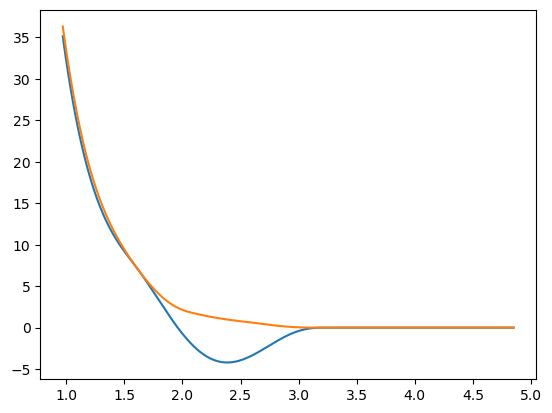

In [65]:
coef_dict, knot_dict = fit_sample(sample, F_nknots=3, Rho_nknots=3, V_nknots=4)

print(coef_dict, knot_dict)

with open("Init.json", "r") as json_file:
    loaded_data = json.load(json_file)

pot = {}
for key, value in loaded_data.items():
    pot[key] = np.array(value)

pot_old = copy.deepcopy(pot)

pot = update_potfile(pot,pot_params, coef_dict, knot_dict)

rho = np.linspace(0, pot_params['drho']*(pot_params['Nrho']-1), pot_params['Nrho'])
r = np.linspace(0, pot_params['dr']*(pot_params['Nr']-1), pot_params['Nr'])

k = 1000

plt.plot(r[k:], pot['W-He'][k:])
plt.plot(r[k:], pot_old['W-He'][k:])

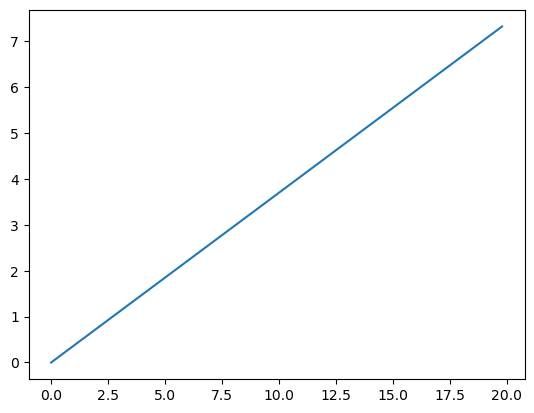

In [59]:
plt.plot(rho, pot['He_F(rho)'])


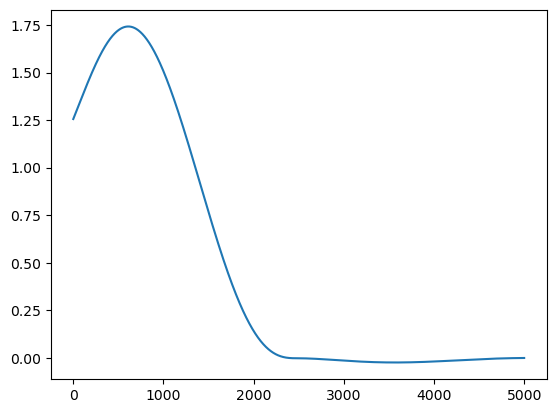

In [64]:
with open("Final.json", "r") as json_file:
    loaded_data = json.load(json_file)

pot = {}
for key, value in loaded_data.items():
    pot[key] = np.array(value)


plt.plot(pot['He_rho(r)'])